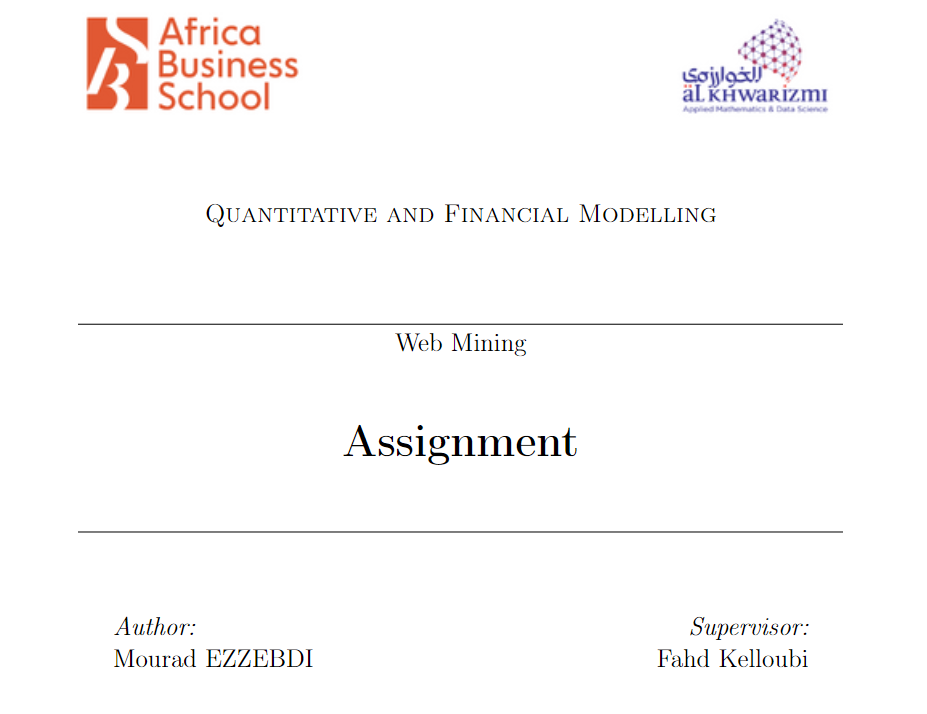

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd

import json
import plotly.express as px
import plotly.graph_objs as go

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

"""Building the functions required to scrape the website"""

# ---------------------------------------------------------------------------

def get_country_data(country_line):
    """
    This function formats a given input line parsed from an html page.

    Parameters:
        country_line : str
            it is a row table row, that contains the data.

    Returns:
        line : list
            A list containing all the useful information retrieved.
    """
    import re
    line = country_line.strip().split("\n")
    line.pop(0)
    for i, element in zip(range(len(line)), line):
        if re.search("[1-9]+", element):
            line[i] = float(''.join(line[i].strip('+').split(",")))
        else:
            pass

    return line[:-1]


def get_column_names(tr):
    """
    This function returns a well formatted list for the column names.
    """
    line = tr.strip("\n#").strip().split("\n")
    line[12] += line[13]
    line.pop(14)
    line.pop(13)

    # Remove non-ASCII characters from column names
    line = [col.encode("ascii", "ignore").decode() for col in line]

    return line[1:-1]



def scrape_corona_data():
    """
    This function scrapes the data from the target website and returns a well formatted dict that contains information about every given country.
    """
    from collections import \
        defaultdict  # Importing the defaultdict model, that will be used to store the information while scraping the website
    countries_data = defaultdict(dict)
    coronameter = requests.get(
        "https://www.worldometers.info/coronavirus/")  # requesting the index page from the server, it is also where our information resides
    bscorona = BeautifulSoup(coronameter.text, "lxml")  # parsing the webpage to a beautifulsoup object.
    corona_table = bscorona.find("table",
                                 id="main_table_countries_today")  # selecting the table where our data is contained.
    print(corona_table.tr.text)
    column_names = get_column_names(corona_table.tr.text)
    print(column_names)
    for tr in corona_table.find_all("tr", {"style": ""})[2:-2]:
        line = get_country_data(tr.text)
        countries_data[line[0]] = {
            key: list(value) if isinstance(value, set) else value
            for key, value in zip(column_names, line[1:])
        }

    return countries_data


def replace_nan(data):
    """
    This function replaces empty or N/A values with np.nan so that it can be easier to manipulate the data later on.
    """
    for col in data.columns:
        data[col].replace(["N/A", "", " ", "-"], np.nan, inplace=True)

def create_clean_dataframe(countries_data):

    data = pd.DataFrame(countries_data).transpose()
    replace_nan(data)
    return data


"""Building the plotting functions"""

# ---------------------------------------------------------------------------

def plot_continent_data(data, keyword):
    """
    This function creates a Figure from continental data.

    Parameters:
        data : dataframe
            The whole dataset.
        keyword : str
            The keyword used to define the figure wanted, the available keyword : {"Total", "New"}

    Returns:
        fig : Figure
            The figure that will be drawed on plotly.
    """
    if keyword == "New":
        cols = ["NewCases", "NewRecovered", "NewDeaths"]
    else:
        cols = ["TotalCases", "TotalRecovered", "TotalDeaths"]
    res = data.groupby("Continent")[cols].sum()

    plot_data = []
    colors = ["#031cfc", "#24b514", "#d11d1d"]
    for col, color in zip(cols, colors):
        plot_data.append(go.Bar(x=res.index.to_list(), y=res[col], name=col, marker=dict(color=color)))

    layout = go.Layout(title=f"Corona {keyword} Cases/Recovered/Deaths",
                       xaxis=dict(title="Continents"),
                       yaxis=dict(title="Cases per Continent"))

    fig = go.Figure(data=plot_data, layout=layout)
    return fig


def get_continent_sorted_data(data, continent, sortedby="TotalCases", ascending=False):
    """
    This function creates a sorted dataframe related to a continent and sorted by a columns.

    Parameters:
        data : dataframe
            The whole dataset.
        continent : str
            The continent we want to get the data from.
        sortedby : str, Default="TotalCases"
            The name of the column we want to sort by.
        ascending : Boolean, Default=False
            Either we want to sort in an ascending order or descending order.
    Returns:
        groupedbydata : dataframe
            A dataframe groupedby the continent.
    """
    return data.groupby("Continent").get_group(continent).sort_values(by=sortedby, ascending=ascending).reset_index()



def get_top_k_countries(data, k_countries=10, sortedby="TotalCases", ascending=False):
    """
    This function creates a k-len dataframe sorted by a key.

    Parameters:
        data : dataframe.
            The whole dataset.
        k_countries : int, Default=10
            The number of countries you want to plot.
        sortedby : str, Default="TotalCases".
            The column name we want to sort the data by
        ascending : Boolean, Default=False
            Either we want to sort in an ascending order or descending order.

    Returns:
        data : dataframe
            The k_contries lines dataframe sortedby the key given and in the wanted order.
    """
    return data.sort_values(by=sortedby, ascending=ascending).iloc[:k_countries]


def plot_top_k_countries(data, n_countries, sortby):
    """This function returns a figure where a number of countries are sorted by the value that resides in sortby."""
    res = get_top_k_countries(data, n_countries, sortby)
    plot_data = []

    plot_data.append(go.Bar(x=res.index.to_list(), y=res[sortby], name=sortby))

    layout = go.Layout(title=f"Top Countries orderedby {sortby}",
                       xaxis=dict(title="Countries"),
                       yaxis=dict(title=f"{sortby}"))

    fig = go.Figure(data=plot_data, layout=layout)
    return fig


def plot_boxplots(data, keyword="Deaths/1M pop"):
    """This function returns a figure of the boxplot related to each continent in regards to the keyword."""
    plot_data = []
    grouped_data = data.groupby("Continent")
    continents = data["Continent"].value_counts().index.to_list()
    for continent in continents:
        plot_data.append(go.Box(y=grouped_data.get_group(continent)[keyword], name=continent))
    layout = go.Layout(title=f"Boxplots using {keyword}",
                       xaxis=dict(title="Continents"),
                       yaxis=dict(title=f"{keyword}"))
    fig = go.Figure(data=plot_data, layout=layout)
    return fig

def plot_bar(data, x, y1,y2,y3, title):
    
    """This function returns a bar plot."""
    '''
    plot_data = [go.Bar(x=data[x], y=data[y])]
    layout = go.Layout(title=title, xaxis=dict(title=x), yaxis=dict(title=y))
    fig = go.Figure(data=plot_data, layout=layout)
    return fig
    '''
    fig = px.bar(data, x=x, y=[y1, y2,y3], title="")
    return fig

def plot_scatter(data, x, y, title):
    
    """This function returns a scatter plot"""
    
    plot_data = [go.Scatter(x=data[x], y=data[y], mode='markers')]
    layout = go.Layout(title=title, xaxis=dict(title=x), yaxis=dict(title=y))
    fig = go.Figure(data=plot_data, layout=layout)
    return fig


def plot_pie(data, labels, values, title):
    plot_data = [go.Pie(labels=data[labels], values=data[values])]
    layout = go.Layout(title=title)
    fig = go.Figure(data=plot_data, layout=layout)
    return fig


    
    
def init_figure():
    """
    This function initializes all the necessary figures to start the app.
    """
    countries_data = scrape_corona_data()
    data = create_clean_dataframe(countries_data)

    scatter_fig = plot_scatter(data, x="TotalCases", y="TotalTests", title="Total Tests vs Total Cases")

    bar_data = data.groupby("Continent").sum().reset_index()
    
    pie_data = data.groupby("Continent")["TotalDeaths"].sum().reset_index()
    pie_data2 = data.groupby('Continent')["TotalCases"].sum().reset_index()
    pie_fig = plot_pie(pie_data, labels="Continent", values="TotalDeaths", title="Total Deaths by Continent")
    pie_fig2 = plot_pie(pie_data2,labels='Continent',values = "TotalCases",title="Total cases by Continent")
    
    bar_fig = plot_bar(bar_data, x="Continent", y1="TotalCases",y2='TotalRecovered',y3 = 'TotalDeaths', title="Total Cases by Continent")
    
    
    init_continent_fig = plot_continent_data(data, keyword="New")
    init_k_countries_plot = plot_top_k_countries(data, 10, "TotalCases")
    init_box_fig = plot_boxplots(data, keyword="Deaths/1M pop")

    return init_continent_fig, init_k_countries_plot, init_box_fig, bar_fig, scatter_fig, pie_fig,pie_fig2


countries_data = scrape_corona_data()
data = create_clean_dataframe(countries_data)
figures = init_figure()
init_continent_fig, init_k_countries_plot, init_box_fig, bar_fig, scatter_fig, pie_fig,pie_fig2  = figures


#init_continent_fig, init_k_countries_plot, init_box_fig = init_figure()



"""Building the app"""
# ---------------------------------------------------------------------------

# Initializing the app
app = dash.Dash(__name__)
server = app.server

# Building the app layout
app.layout = html.Div([
    html.H1("Corona Tracker DashBoard", style={"text-align": "center"}),
    html.Br(),
    html.Div([
        html.Br(),
        html.H2("Corona Cases/Recovered/Deaths by Continent", style={"text-align": "center"}),
        html.Br(),
        dcc.Dropdown(id="select_keyword",
                     options=[
                         dict(label="Today's Data", value="New"),
                         dict(label="Total Data", value="Total")],
                     multi=False,
                     value="New",
                     style={"width": "40%"}
                     ),

        dcc.Graph(id="continent_corona_bar", figure=init_continent_fig)
    ]),

    html.Div([
        html.Br(),
        html.H2("Visualize Countries by attribute.", style={"text-align": "center"}),
        html.Br(),
        dcc.Dropdown(id="select_attribute",
                     options=[
                         dict(label="Total Cases", value='TotalCases'),
                         dict(label="New Cases", value='NewCases'),
                         dict(label="Total Cases per 1M population", value='Tot Cases/1M pop'),
                         dict(label="Active Cases", value='ActiveCases'),
                         dict(label="Serious, Critical Cases", value='Serious,Critical'),
                         dict(label="Total Deaths", value='TotalDeaths'),
                         dict(label="New Deaths", value='NewDeaths'),
                         dict(label="Deaths per 1M population", value='Deaths/1M pop'),
                         dict(label="Total Recovered", value='TotalRecovered'),
                         dict(label="New Recovered", value='NewRecovered'),
                         dict(label="Total Tests", value='TotalTests'),
                         dict(label="Tests per 1M population", value='Tests/1M pop')],
                     multi=False,
                     value="TotalCases",
                     style={"width": "60%", 'display': 'inline-block'}
                     ),
        dcc.Dropdown(id="select_k_countries",
                     options=[
                         dict(label="Top 5", value=5),
                         dict(label="Top 10", value=10),
                         dict(label="Top 25", value=25),
                         dict(label="Top 50", value=50),
                     ],
                     multi=False,
                     value=10,
                     style={"width": "30%", 'display': 'inline-block'}
                     ),

        dcc.Graph(id="k_countries_sorted", figure=init_k_countries_plot)
    ]),

    html.Div([
        html.Br(),
        html.H2("BoxPlot to explain the distribution of the variables", style={"text-align": "center"}),
        html.Br(),
        dcc.Dropdown(id="select_box_attribute",
                     options=[
                         dict(label="Deaths per 1M population", value='Deaths/1M pop'),
                         dict(label="Tests per 1M population", value='Tests/1M pop')
                     ],
                     multi=False,
                     value="Deaths/1M pop",
                     style={"width": "40%"}
                     ),

        dcc.Graph(id="continent_box_plot", figure=init_box_fig)
    ]),

    html.Div([
        html.Br(),
        html.H2("Additional Plots", style={"text-align": "center"}),
        html.Br(),
        dcc.Graph(id="bar_plot", figure=bar_fig),
        dcc.Graph(id="scatter_plot", figure=scatter_fig),
        dcc.Graph(id="pie_chart", figure=pie_fig),
        dcc.Graph(id="pie_chart", figure=pie_fig2)
    ])
])

# Defining the application callbacks

@app.callback(
    Output("continent_corona_bar", "figure"),
    Input("select_keyword", "value")
)
def update_continent_corona_bar(value):
    return plot_continent_data(data, keyword=value)

@app.callback(
    Output("k_countries_sorted", "figure"),
    Input("select_attribute", "value"),
    Input("select_k_countries", "value")
)
def update_k_countries_sorted(attribute, n_countries):
    return plot_top_k_countries(data, n_countries, attribute)

@app.callback(
    Output("continent_box_plot", "figure"),
    Input("select_box_attribute", "value")
)
def update_continent_box_plot(value):
    return plot_boxplots(data, keyword=value)


@app.callback(
    Output("bar_plot", "figure"),
    Input("select_attribute", "value")
)
def update_bar_plot(attribute):
    return plot_bar(data, attribute)


@app.callback(
    Output("scatter_plot", "figure"),
    Input("select_attribute", "value")
)
def update_scatter_plot(attribute):
    return plot_scatter(data, attribute)


@app.callback(
    Output("pie_chart", "figure"),
    Input("select_attribute", "value")
)
def update_pie_chart(attribute):
    return plot_pie(data, attribute)

if __name__ == "__main__":
    figures = init_figure()
    app.run_server()



C:\Users\21261\AppData\Local\Temp\ipykernel_11088\607752000.py:11: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\21261\AppData\Local\Temp\ipykernel_11088\607752000.py:12: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html



#
Country,Other
TotalCases
NewCases
TotalDeaths
NewDeaths
TotalRecovered
NewRecovered
ActiveCases
Serious,Critical
Tot Cases/1M pop
Deaths/1M pop
TotalTests
Tests/
1M pop

Population
Continent
1 Caseevery X ppl1 Deathevery X ppl1 Testevery X ppl
New Cases/1M pop
New Deaths/1M pop
Active Cases/1M pop

['TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases', 'Serious,Critical', 'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', 'Population', 'Continent', '1 Caseevery X ppl1 Deathevery X ppl1 Testevery X ppl', 'New Cases/1M pop', 'New Deaths/1M pop']

#
Country,Other
TotalCases
NewCases
TotalDeaths
NewDeaths
TotalRecovered
NewRecovered
ActiveCases
Serious,Critical
Tot Cases/1M pop
Deaths/1M pop
TotalTests
Tests/
1M pop

Population
Continent
1 Caseevery X ppl1 Deathevery X ppl1 Testevery X ppl
New Cases/1M pop
New Deaths/1M pop
Active Cases/1M pop

['TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRec

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
[2023-05-28 18:38:35,700] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\Users\21261\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\21261\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\21261\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\21261\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\21261\anaconda3\lib\site-packages\flask\app.py", line 1948, in full_dispatch_request
    rv = self.preprocess_request()
  File "C:\Users\21261\anaconda3\lib\site-packages\flask\app.py", line 2242, in preprocess_request
    rv = func()
  File "C:\Users\21261\anaconda3\lib\site-packages\dash\dash.py", line 13

## Output of the web app :

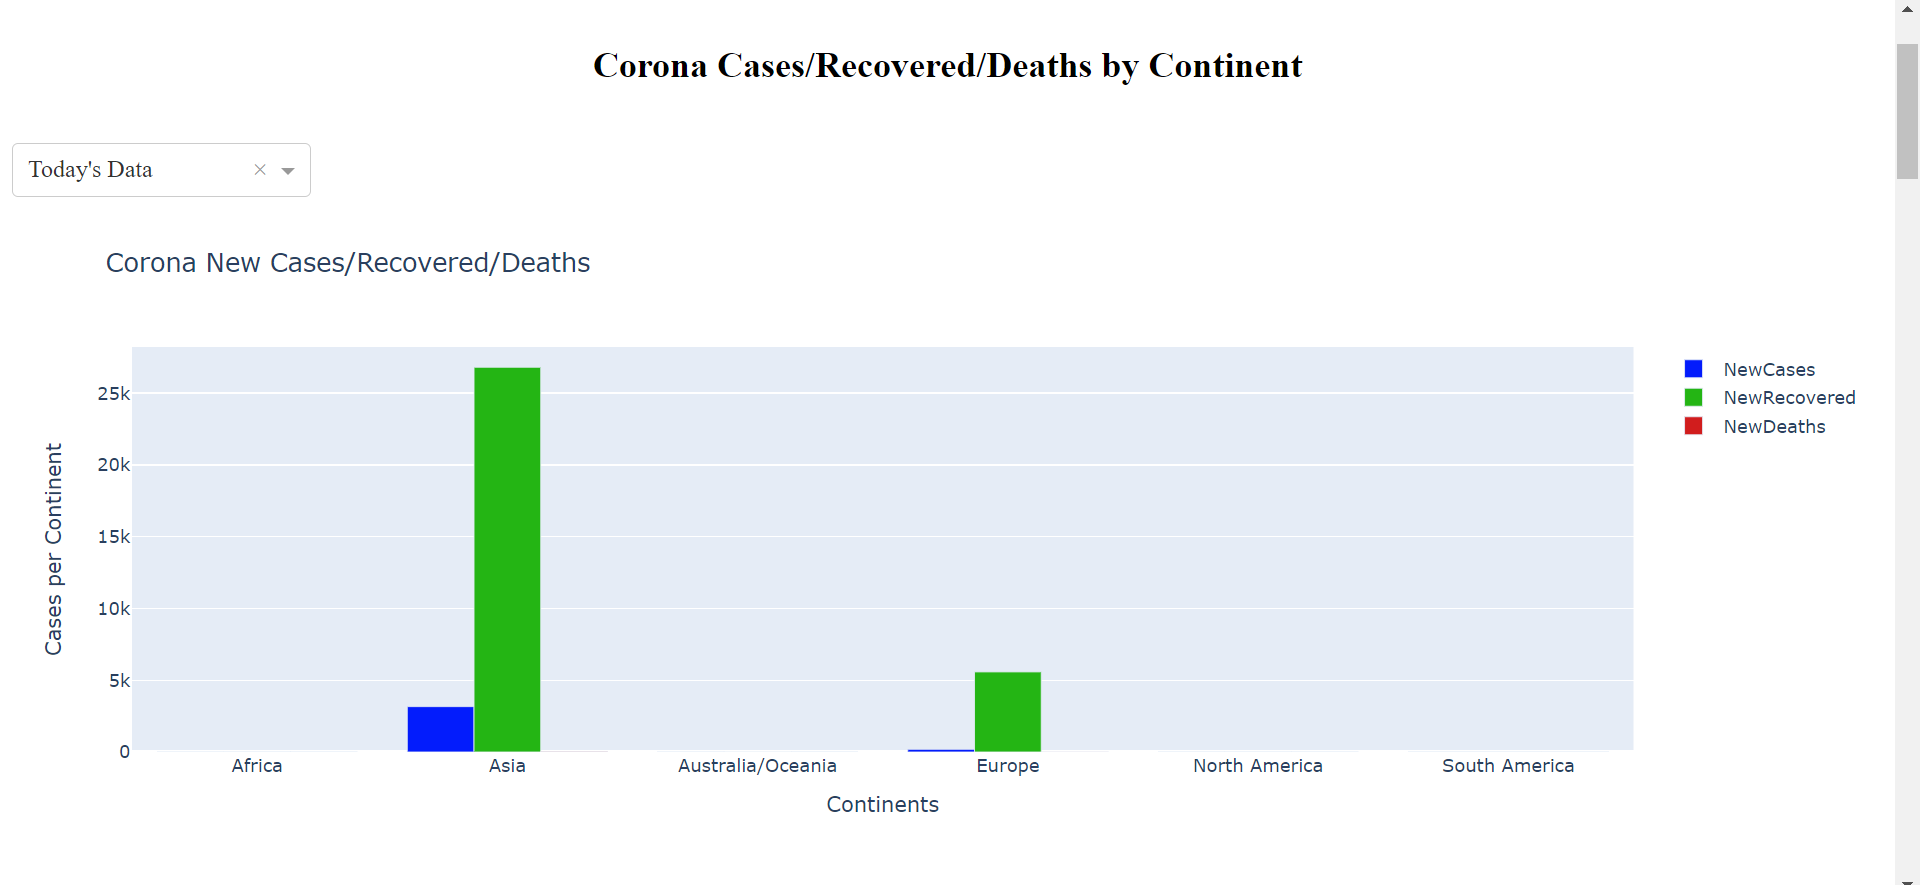

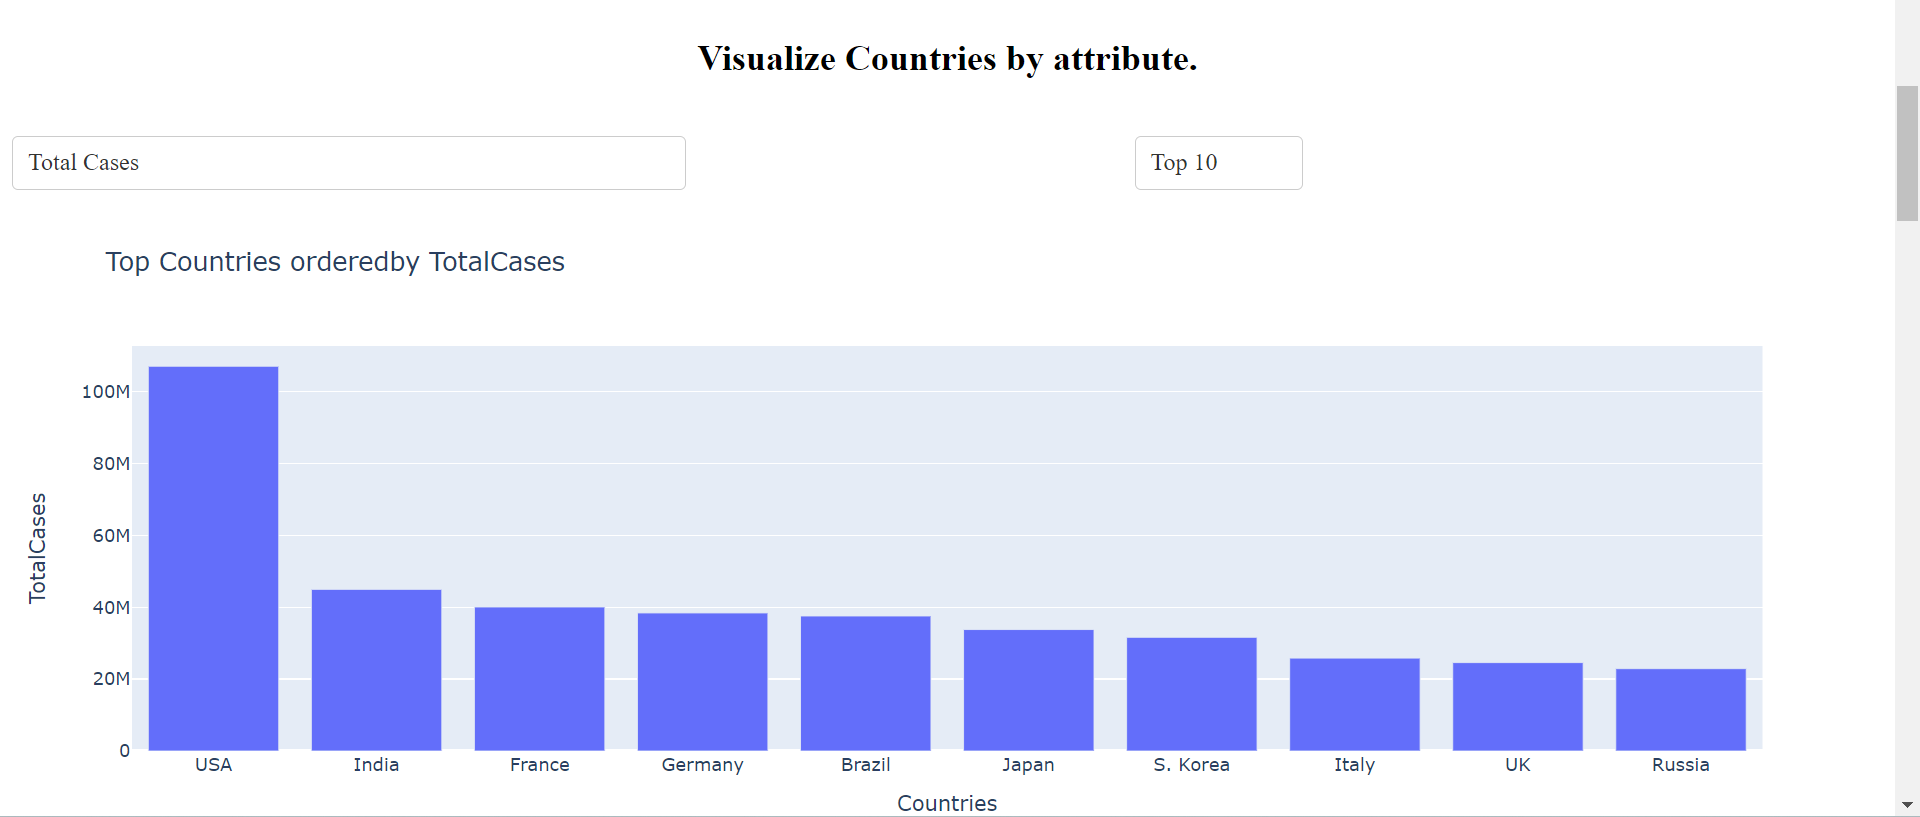

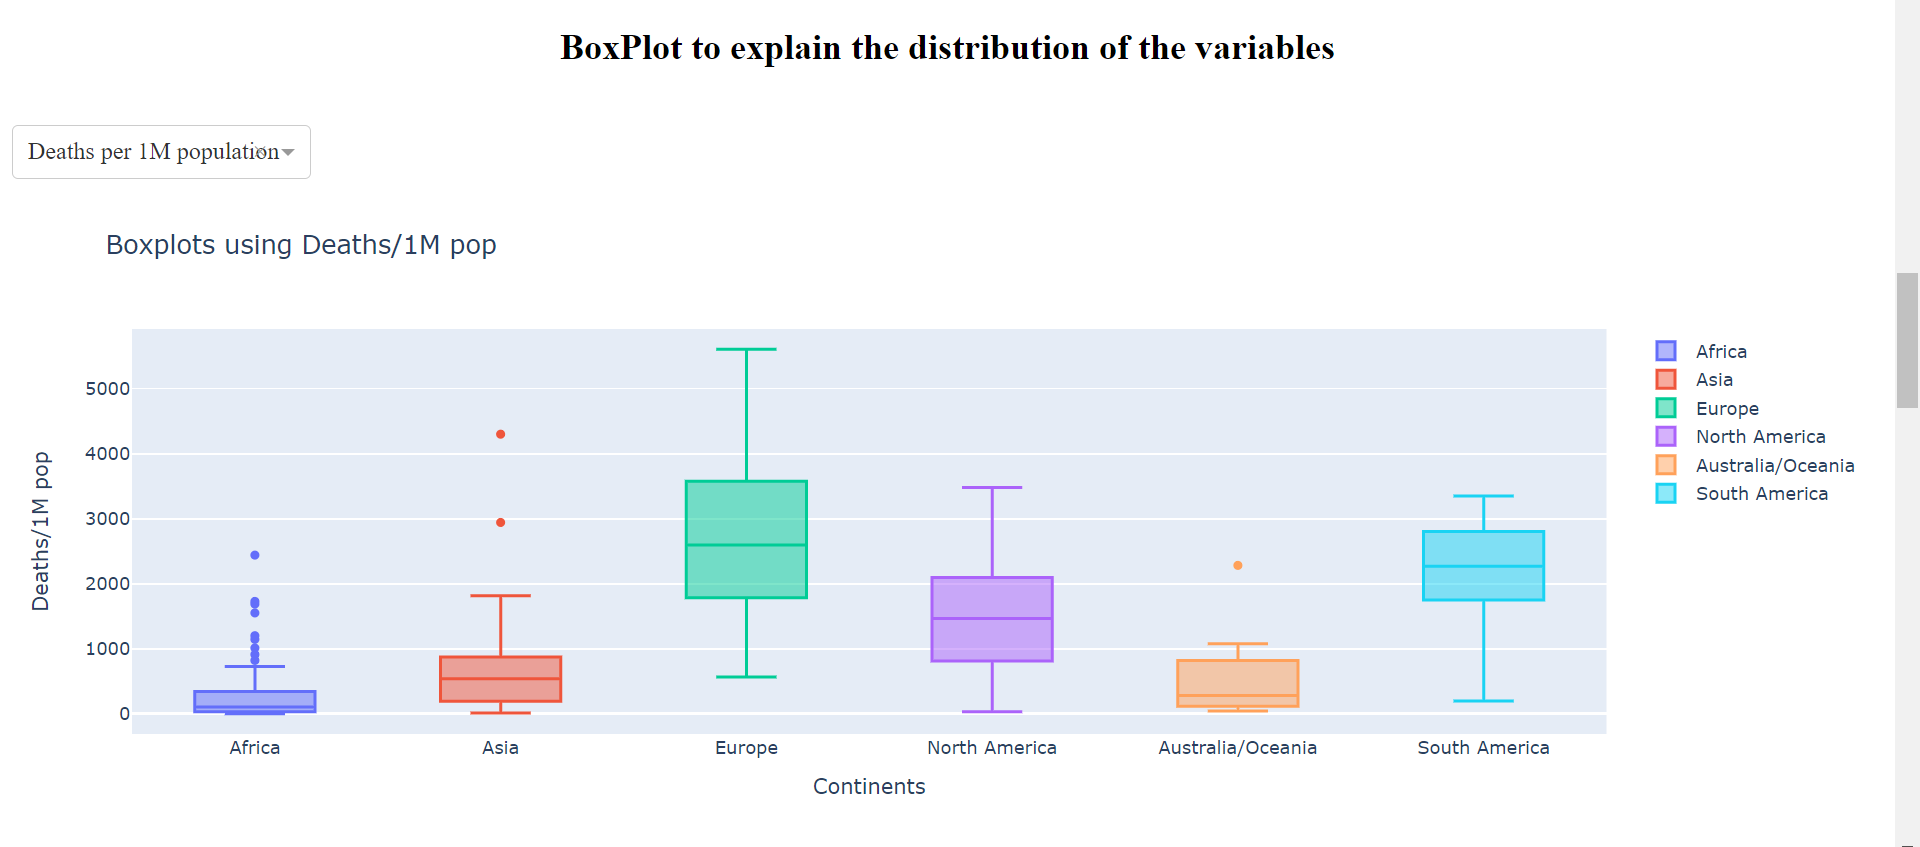

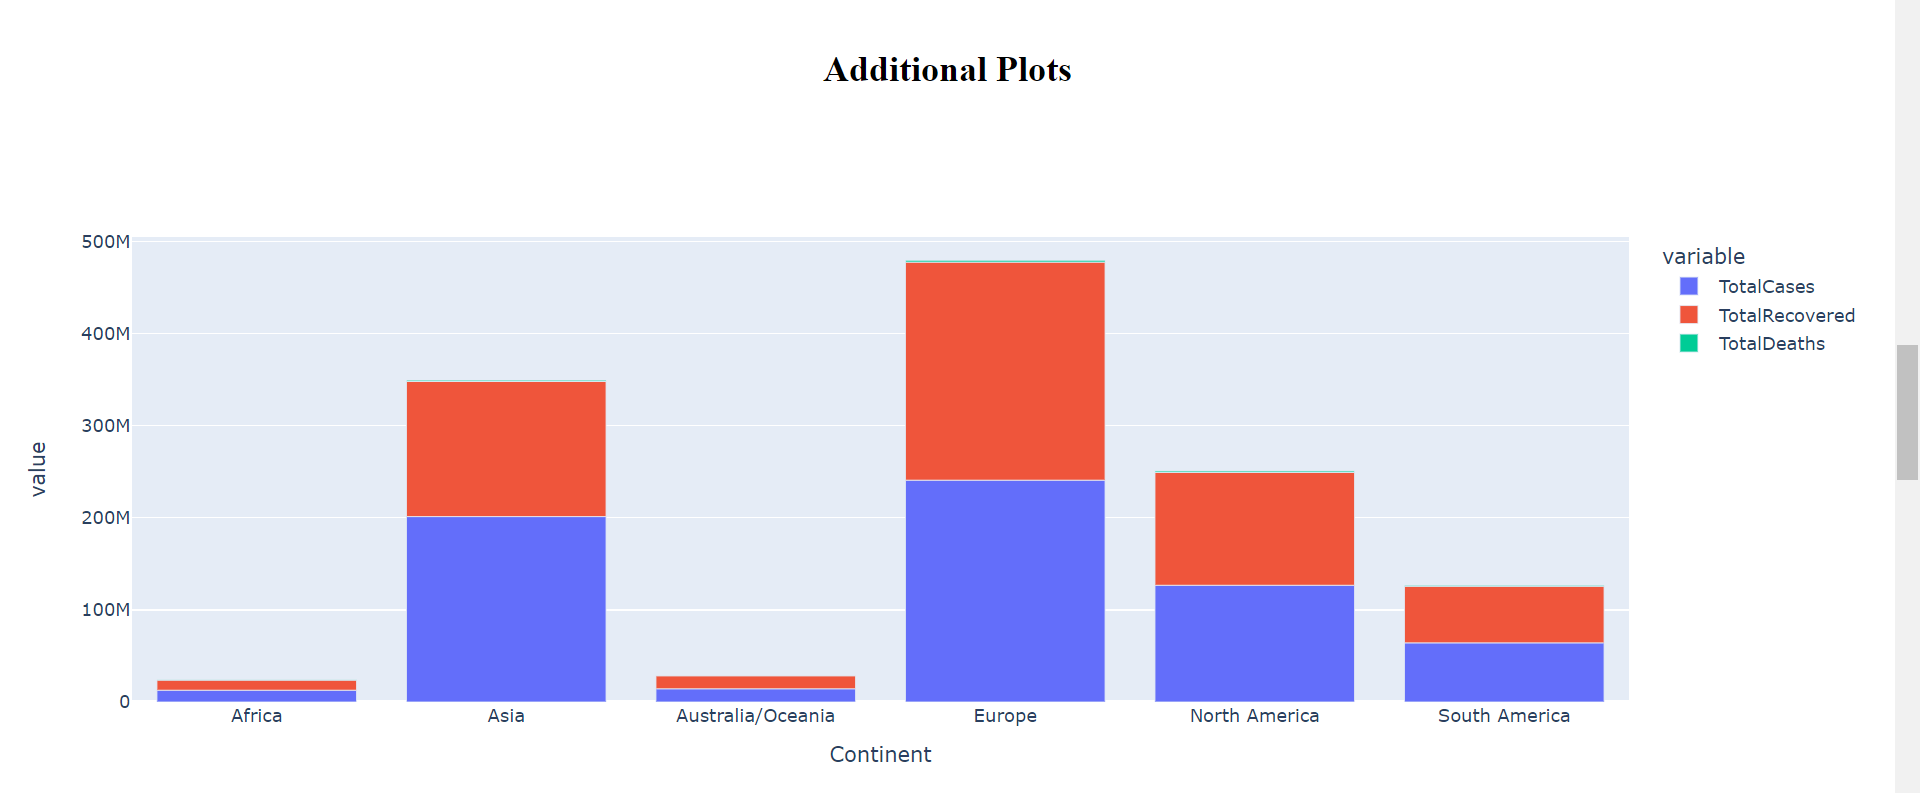

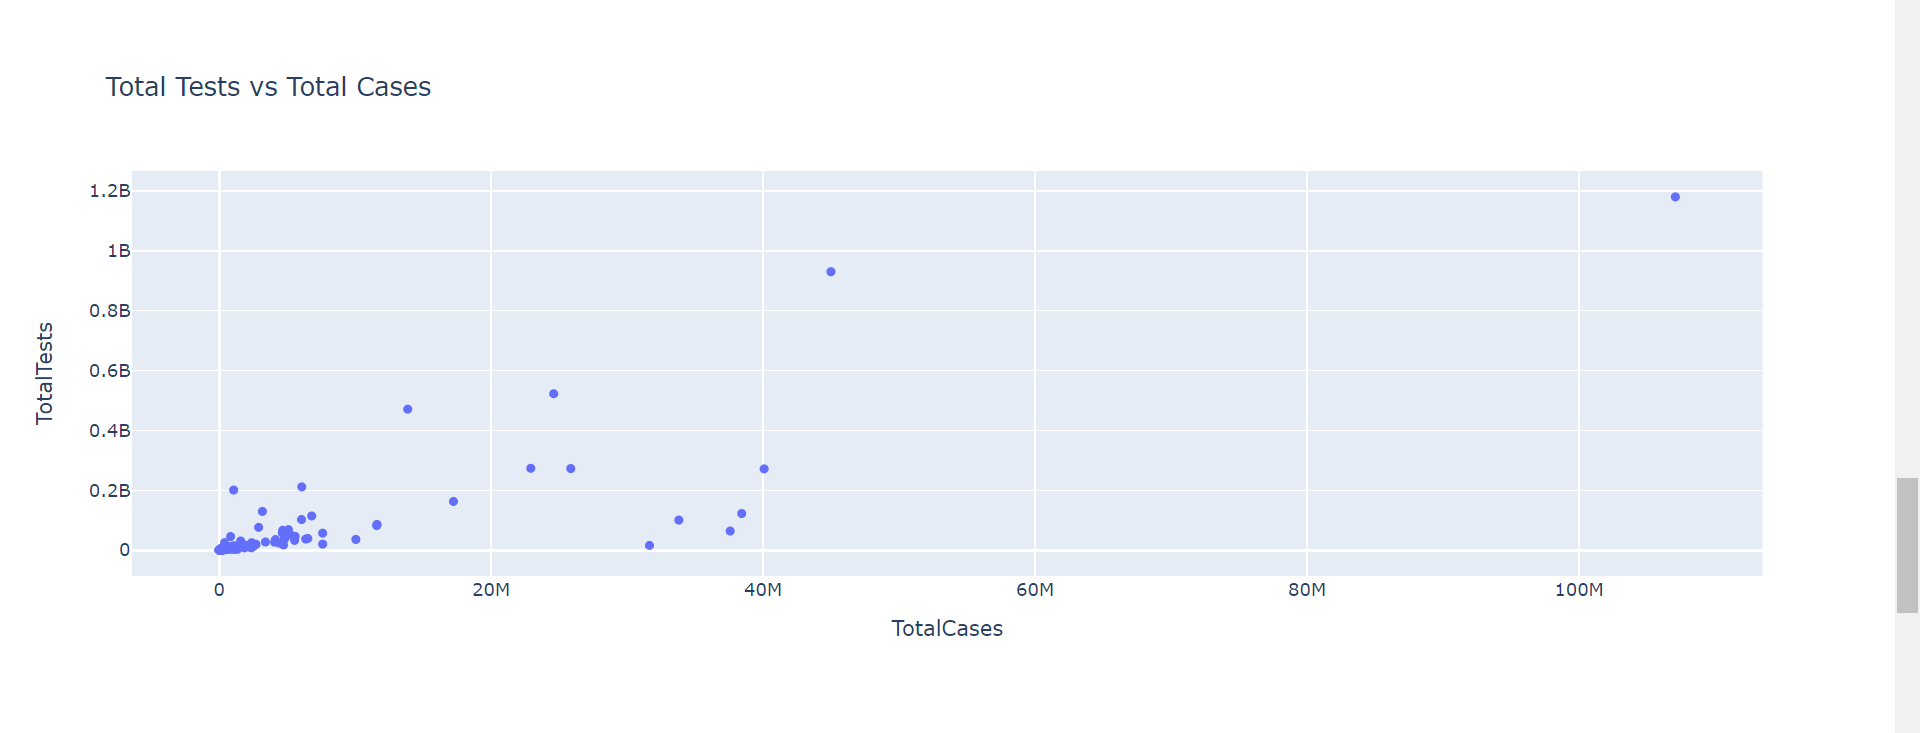

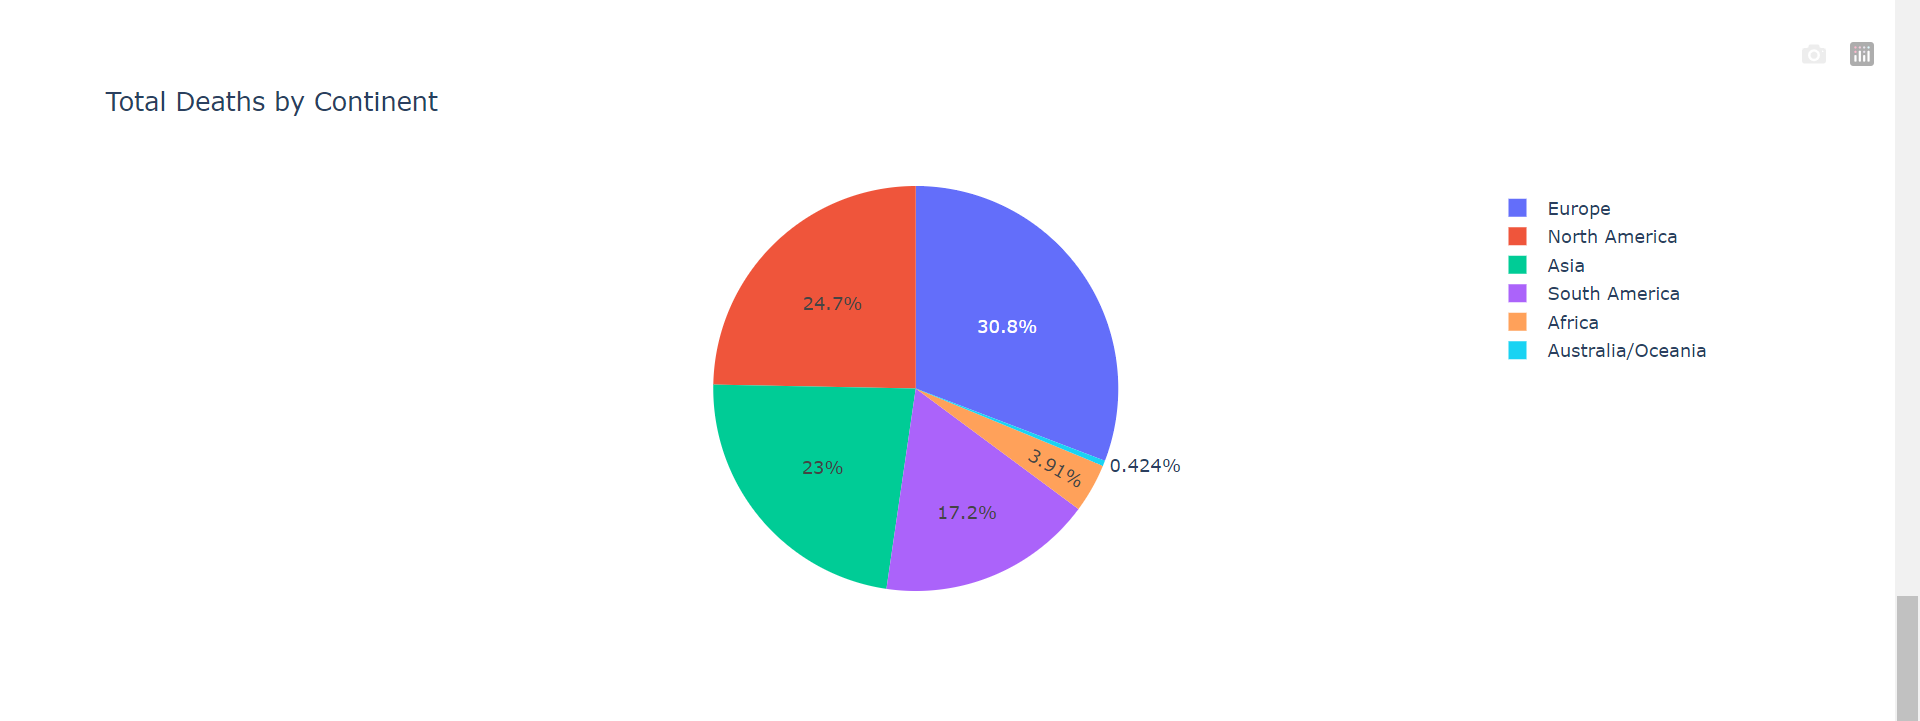

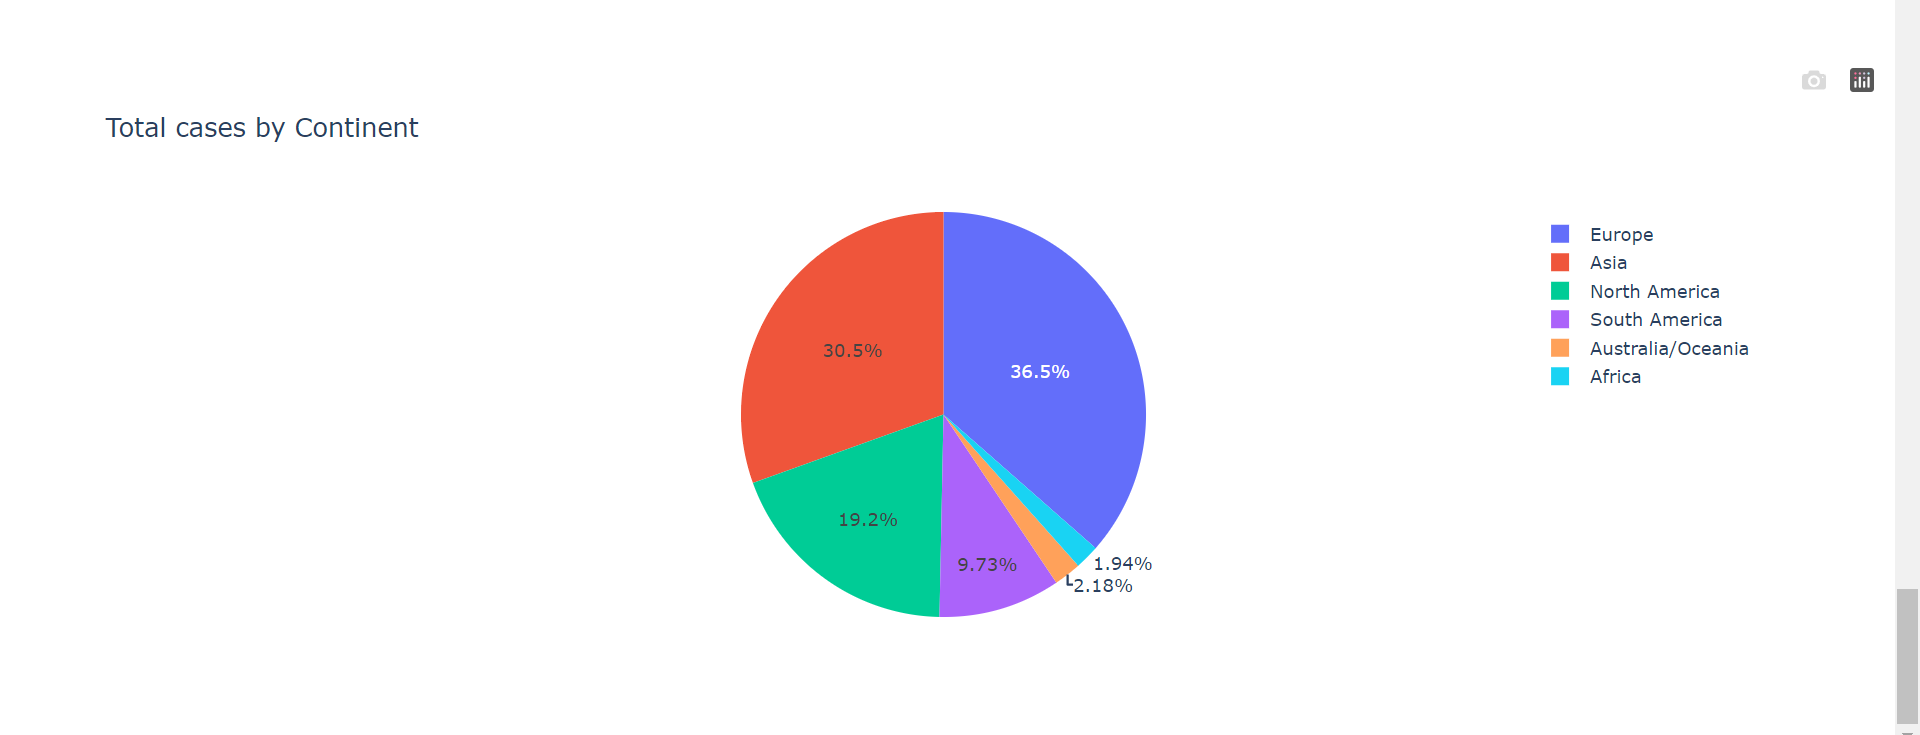